In [1]:
import importlib
import pandas as pd
from matplotlib import pyplot as plt
import plot_functions
import numpy as np
import scipy as sp

In [2]:
importlib.reload(plot_functions)

<module 'plot_functions' from '/Users/dlehotzk/Documents/tcga/dig/plot_functions.py'>

# DIG input

In [3]:
df_res = pd.read_csv('out.tsv', sep='\t', names=['CHROM', 'START', 'END', 'REF', 'ALT', 'SAMPLE', 'GENE', 'ANNOT', 'MUT_TYPE', 'CONTEXT'])

In [4]:
df_res

,CHROM,START,END,REF,ALT,SAMPLE,GENE,ANNOT,MUT_TYPE,CONTEXT
0,1,566107,566108,A,G,TCGA-WC-AA9A-01A,.,Noncoding,A>G,TAA
1,1,569341,569342,T,C,TCGA-V4-A9ES-01A,.,Noncoding,T>C,CTC
2,1,569517,569518,G,A,TCGA-VD-A8KF-01A,.,Noncoding,G>A,AGC
3,1,752696,752697,G,A,TCGA-YZ-A985-01A,.,Noncoding,G>A,CGT
4,1,872255,872256,T,G,TCGA-V4-A9F5-01A,.,Noncoding,T>G,TTG
...,...,...,...,...,...,...,...,...,...,...
152009,22,51093797,51093798,C,-,TCGA-VD-AA8O-01A,.,INDEL,Noncoding_INDEL,.
152010,22,51140977,51140978,G,A,TCGA-YZ-A985-01A,.,Noncoding,G>A,CGC
152011,22,51141986,51141987,G,A,TCGA-YZ-A985-01A,.,Noncoding,G>A,CGC
152012,22,51169437,51169438,G,A,TCGA-YZ-A985-01A,SHANK3,Missense,G>A,CGC


In [5]:
df_res.SAMPLE.unique().shape[0]

71

# Mutation burden across samples within the cohort

TCGA-YZ-A985-01A: 25000 number of mutations


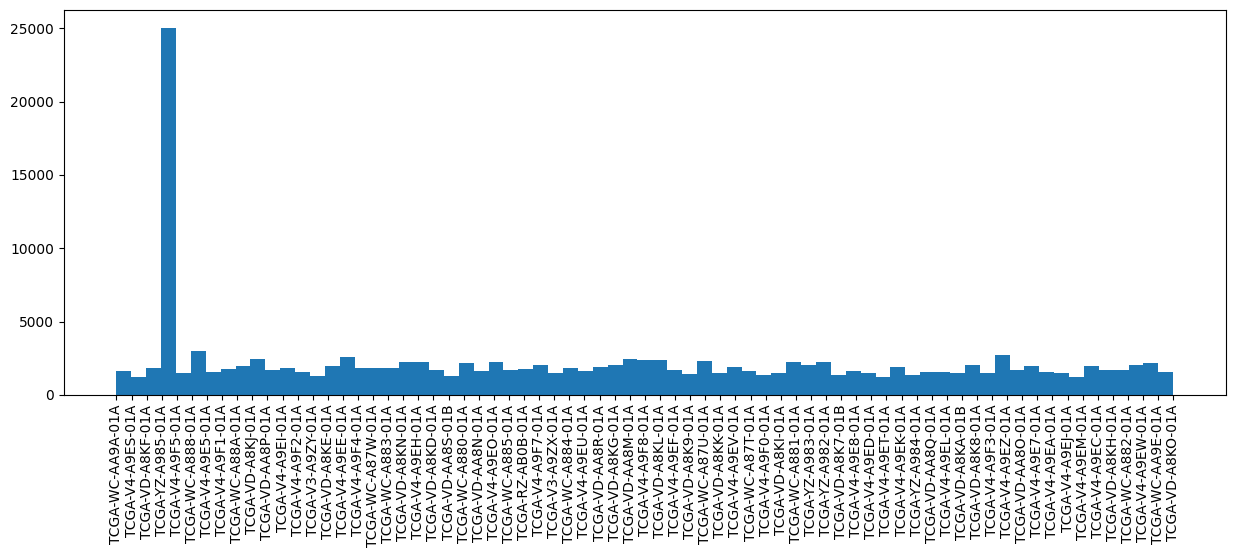

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(df_res.SAMPLE, bins=df_res.SAMPLE.unique().shape[0])
ax.tick_params(axis='x', labelrotation=90)
ids, cts = np.unique(df_res.SAMPLE, return_counts=True)
idx_max = np.argsort(cts)[-1]
print(ids[idx_max] + ': ' + str(cts[idx_max]) + ' number of mutations')
plt.show()

## Excluding outlier

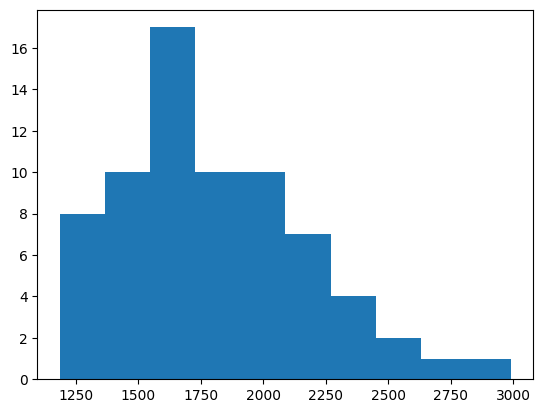

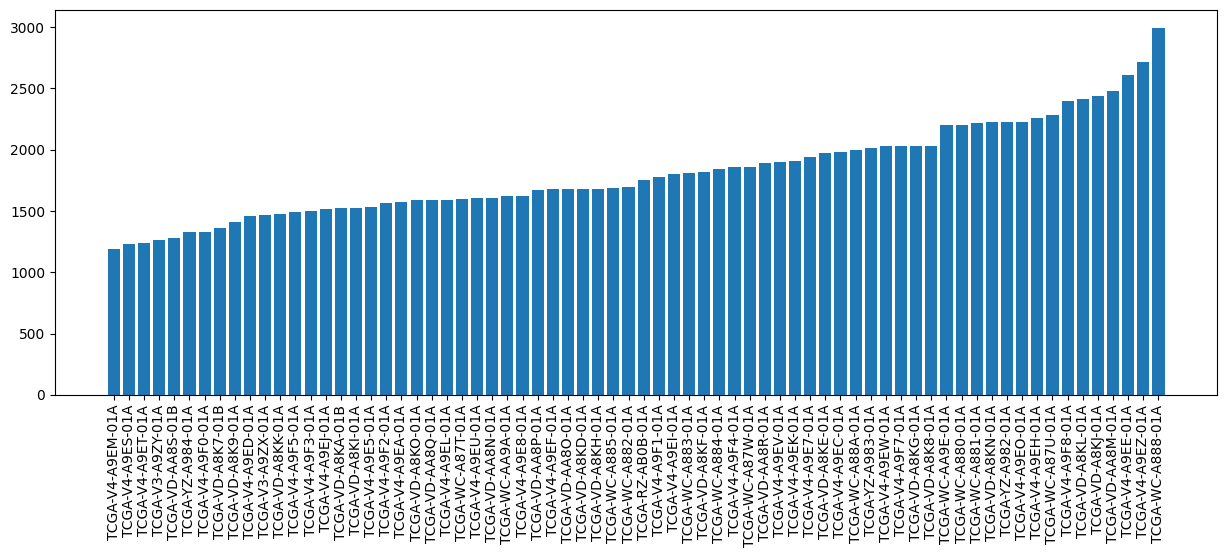

In [7]:
outliers = ['TCGA-YZ-A985-01A']
ids, cts = np.unique(df_res.loc[~df_res.SAMPLE.isin(outliers), 'SAMPLE'], return_counts=True)
plt.hist(cts)
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
ind_sorted = np.argsort(cts)
plt.bar(ids[ind_sorted], cts[ind_sorted])
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# DIG output

## Coding genes

In [8]:
df = pd.read_csv('genes.results.txt', sep='\t')

### Output columns

In [9]:
df.columns.tolist()

['GENE',
 'CHROM',
 'GENE_LENGTH',
 'R_SIZE',
 'R_OBS',
 'R_INDEL',
 'MU',
 'SIGMA',
 'ALPHA',
 'THETA',
 'MU_INDEL',
 'SIGMA_INDEL',
 'ALPHA_INDEL',
 'THETA_INDEL',
 'FLAG',
 'Pi_SYN',
 'Pi_MIS',
 'Pi_NONS',
 'Pi_SPL',
 'Pi_TRUNC',
 'Pi_NONSYN',
 'Pi_INDEL',
 'OBS_SYN',
 'OBS_MIS',
 'OBS_NONS',
 'OBS_SPL',
 'OBS_INDEL',
 'OBS_TRUNC',
 'OBS_NONSYN',
 'N_SAMP_SYN',
 'N_SAMP_MIS',
 'N_SAMP_NONS',
 'N_SAMP_SPL',
 'N_SAMP_TRUNC',
 'N_SAMP_NONSYN',
 'N_SAMP_INDEL',
 'EXP_SYN',
 'EXP_MIS',
 'EXP_NONS',
 'EXP_SPL',
 'EXP_TRUNC',
 'EXP_NONSYN',
 'PVAL_SYN_BURDEN',
 'PVAL_MIS_BURDEN',
 'PVAL_NONS_BURDEN',
 'PVAL_SPL_BURDEN',
 'PVAL_TRUNC_BURDEN',
 'PVAL_NONSYN_BURDEN',
 'PVAL_SYN_BURDEN_SAMPLE',
 'PVAL_MIS_BURDEN_SAMPLE',
 'PVAL_NONS_BURDEN_SAMPLE',
 'PVAL_SPL_BURDEN_SAMPLE',
 'PVAL_TRUNC_BURDEN_SAMPLE',
 'PVAL_NONSYN_BURDEN_SAMPLE',
 'EXP_INDEL',
 'PVAL_INDEL_BURDEN',
 'PVAL_MUT_BURDEN']

### Results for given mutation burden type

/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


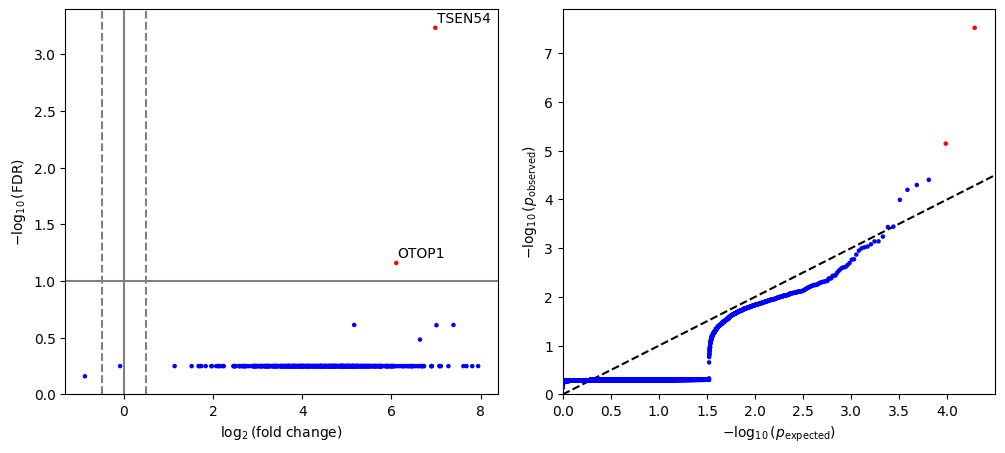

In [10]:
mtype = 'SYN'
d = np.log2(df['OBS_' + mtype]) - np.log2(df['EXP_' + mtype])
p = df['PVAL_' + mtype + '_BURDEN']
l = df.GENE
plot_functions.plot_volcano(p, d, l)

### Distribution of GP parameters

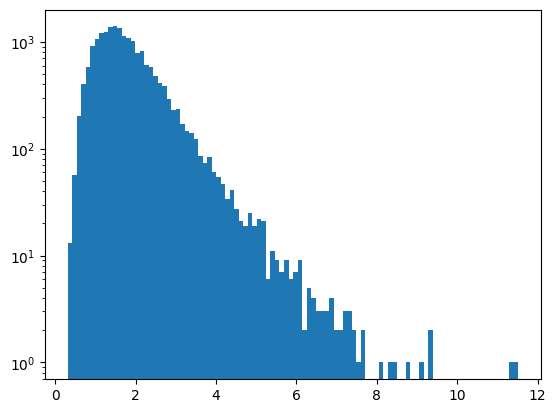

In [11]:
plt.hist(df.SIGMA, bins=100, log=True)
plt.show()

### Recomputing p-values from model parameters

In [12]:
def nb_pvalue_greater_midp(k, alpha, p):
    """ Calculate an UPPER TAIL p-value for a negative binomial distribution with a midp correction
    """
    return 0.5 * sp.stats.nbinom.pmf(k, alpha, p) + sp.special.betainc(k+1, alpha, 1-p)

def nb_pvalue_lower(k, alpha, p):
    return sp.special.betainc(k+1, alpha, 1-p)

def nb_pvalue_upper(k, alpha, p):
    ind_0 = k==0
    pvals = np.zeros_like(alpha)
    pvals[ind_0] = sp.stats.nbinom.pmf(k[ind_0], alpha[ind_0], p[ind_0])
    pvals[~ind_0] = sp.special.betainc(k[~ind_0], alpha[~ind_0], 1-p[~ind_0])
    return pvals

def nb_pvalue_uniform_midp(k, alpha, p):
    """ Calculate the upper tail p-value for negative binomial distribution using uniform approximation and a random draw.
    """
    return np.random.uniform(size=k.shape) * sp.stats.nbinom.pmf(k, alpha, p) + sp.special.betainc(k+1, alpha, 1-p)

#### Total burden

In [70]:
muts = ['SYN', 'MIS', 'NONS', 'TRUNC', 'SPL', 'NONSYN', 'MUT']
print('Minimum and maximum differnces between original and recomputed p-values:\n')
for mut in muts:
    if mut=='MUT':
        col_i = 'PVAL_' + mut + '_BURDEN'
        df[col_i + '_recomp'] = np.nan
        df[col_i + '_uniform'] = np.nan
        for idx in df.index:
            # combining p-values using Fisher's method
            df.at[idx, col_i + '_recomp'] = sp.stats.combine_pvalues([df.at[idx, 'PVAL_NONSYN_BURDEN_recomp'], df.at[idx, 'PVAL_INDEL_BURDEN']], method='fisher').pvalue
            df.at[idx, col_i + '_uniform'] = sp.stats.combine_pvalues([df.at[idx, 'PVAL_NONSYN_BURDEN_uniform'], df.at[idx, 'PVAL_INDEL_BURDEN']], method='fisher').pvalue
    else:
        # recomputing p-values using DIG's model parameters
        df['PVAL_' + mut + '_BURDEN_recomp'] = nb_pvalue_greater_midp(
            df['OBS_' + mut],
            df.ALPHA,
            1 / (df.THETA * df['Pi_' + mut] + 1)
        )
        df['PVAL_' + mut + '_BURDEN_uniform'] = nb_pvalue_uniform_midp(
                df['OBS_' + mut],
                df.ALPHA,
                1 / (df.THETA * df['Pi_' + mut] + 1)
            )
    print(mut, np.min(df['PVAL_' + mut + '_BURDEN_recomp'] - df['PVAL_' + mut + '_BURDEN']), np.max(df['PVAL_' + mut + '_BURDEN_recomp'] - df['PVAL_' + mut + '_BURDEN']))
    
df['PVAL_INDEL_BURDEN_recomp'] = nb_pvalue_greater_midp(df.OBS_INDEL, df.ALPHA_INDEL, 1 / (df.THETA_INDEL*df.Pi_INDEL + 1))
df['PVAL_INDEL_BURDEN_uniform'] = nb_pvalue_uniform_midp(df.OBS_INDEL, df.ALPHA_INDEL, 1 / (df.THETA_INDEL*df.Pi_INDEL + 1))
print('INDEL', np.min(df['PVAL_INDEL_BURDEN_recomp'] - df['PVAL_INDEL_BURDEN']), np.max(df['PVAL_INDEL_BURDEN_recomp'] - df['PVAL_INDEL_BURDEN']))

Minimum and maximum differnces between original and recomputed p-values:

SYN -1.170175067954915e-13 7.416289804496046e-14
MIS -2.674527266322002e-13 1.6220358389773537e-13
NONS -3.863576125695545e-14 2.0761170560490427e-14
TRUNC -5.484501741648273e-14 2.6867397195928788e-14
SPL -5.3734794391857577e-14 9.2148511043888e-15
NONSYN -1.2922996006636822e-13 1.6575629757653587e-13
MUT -0.6148743092078043 0.3762246949086101
INDEL -1.5765166949677223e-14 1.432187701766452e-14


#### Sample-wise burden

In [14]:
print('Minimum and maximum differnces between original and recomputed p-values:\n')
for mut in muts:
    if mut=='MUT':
        # racomputing p-values by aggregating mutation burdens
        df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] = nb_pvalue_greater_midp(
            df['N_SAMP_NONSYN'] + df['N_SAMP_INDEL'],
            df.ALPHA,
            1 / (df.THETA * (df['Pi_NONS'] + df['Pi_INDEL']) + 1)
        )
        df['PVAL_' + mut + '_BURDEN_SAMPLE_uniform'] = nb_pvalue_uniform_midp(
            df['N_SAMP_NONSYN'] + df['N_SAMP_INDEL'],
            df.ALPHA,
            1 / (df.THETA * (df['Pi_NONS'] + df['Pi_INDEL']) + 1)
            )    
        print(mut, np.min(df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] - df['PVAL_' + mut + '_BURDEN']), np.max(df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] - df['PVAL_' + mut + '_BURDEN']))
    else:
        df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] = nb_pvalue_greater_midp(
                df['N_SAMP_' + mut],
                df.ALPHA,
                1 / (df.THETA * df['Pi_' + mut] + 1)
            )
        df['PVAL_' + mut + '_BURDEN_SAMPLE_uniform'] = nb_pvalue_uniform_midp(
                df['N_SAMP_' + mut],
                df.ALPHA,
                1 / (df.THETA * df['Pi_' + mut] + 1)
            )
        print(mut, np.min(df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] - df['PVAL_' + mut + '_BURDEN_SAMPLE']), np.max(df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] - df['PVAL_' + mut + '_BURDEN_SAMPLE']))

Minimum and maximum differnces between original and recomputed p-values:

SYN -1.170175067954915e-13 7.416289804496046e-14
MIS -2.674527266322002e-13 1.6220358389773537e-13
NONS -3.863576125695545e-14 2.0761170560490427e-14
TRUNC -5.484501741648273e-14 2.6867397195928788e-14
SPL -5.3734794391857577e-14 9.2148511043888e-15
NONSYN -1.2922996006636822e-13 1.6575629757653587e-13
MUT -0.6137014422602022 0.5246556547050266


### Computing lower and upper bounds for p-values

In [15]:
muts = ['SYN', 'MIS', 'NONS', 'TRUNC', 'SPL', 'NONSYN']
for mut in muts:
    # total burden
    df['PVAL_' + mut + '_BURDEN_lower'] = nb_pvalue_lower(
        df['OBS_' + mut],
        df.ALPHA,
        1 / (df.THETA * df['Pi_' + mut] + 1)
    )
    df['PVAL_' + mut + '_BURDEN_upper'] = nb_pvalue_upper(
        df['OBS_' + mut],
        df.ALPHA,
        1 / (df.THETA * df['Pi_' + mut] + 1)
    )
    # sample-wise burden
    df['PVAL_' + mut + '_BURDEN_SAMPLE_lower'] = nb_pvalue_lower(
            df['N_SAMP_' + mut],
            df.ALPHA,
            1 / (df.THETA * df['Pi_' + mut] + 1)
        )
    df['PVAL_' + mut + '_BURDEN_SAMPLE_upper'] = nb_pvalue_upper(
            df['N_SAMP_' + mut],
            df.ALPHA,
            1 / (df.THETA * df['Pi_' + mut] + 1)
        )
# total indel burden
df['PVAL_INDEL_BURDEN_lower'] = nb_pvalue_lower(
    df.OBS_INDEL, 
    df.ALPHA, 
    1 / (df.THETA_INDEL * df.Pi_INDEL + 1)
)
df['PVAL_INDEL_BURDEN_upper'] = nb_pvalue_upper(
    df.OBS_INDEL, 
    df.ALPHA, 
    1 / (df.THETA_INDEL * df.Pi_INDEL + 1)
)

/var/folders/7d/ccyblkpj6wvbl5n45y_l75180000gq/T/ipykernel_7814/2892428053.py:2: RuntimeWarning: divide by zero encountered in log2
  d = np.log2(df['OBS_' + mtype].to_numpy()) - np.log2(df['EXP_' + mtype].to_numpy())
/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/matplotlib/transforms.py:365: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


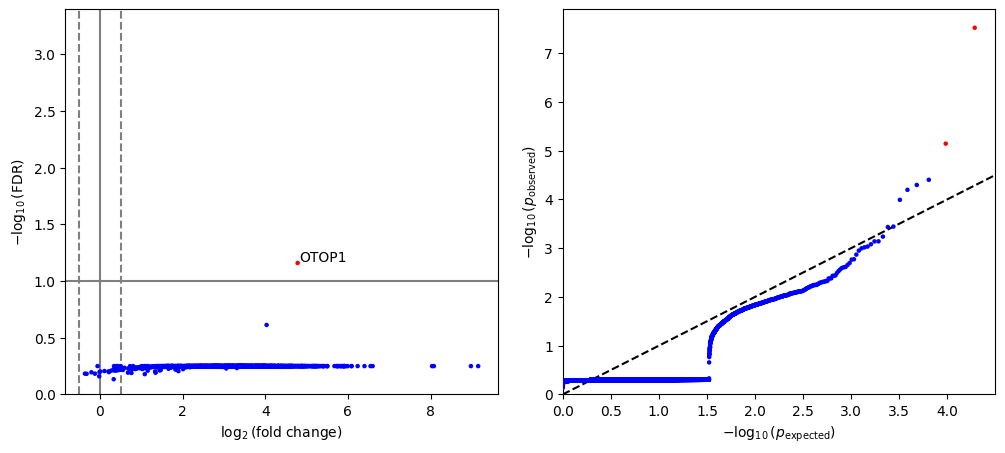

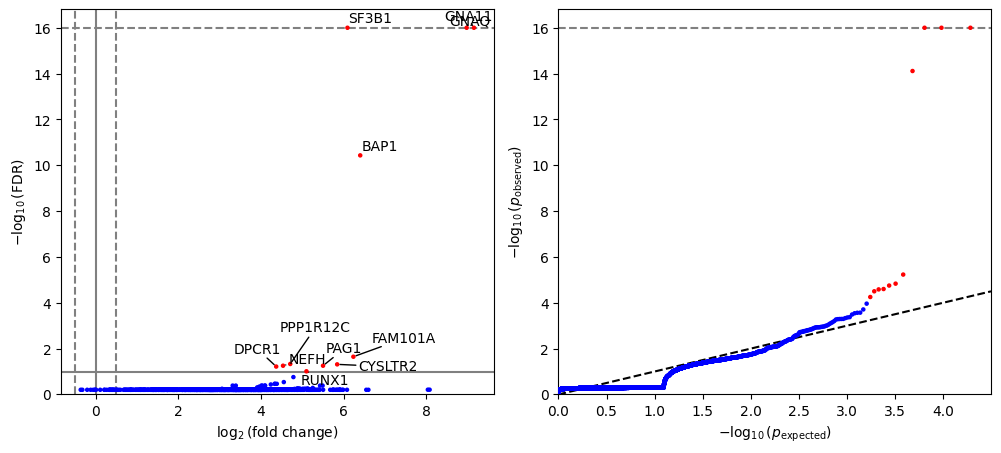

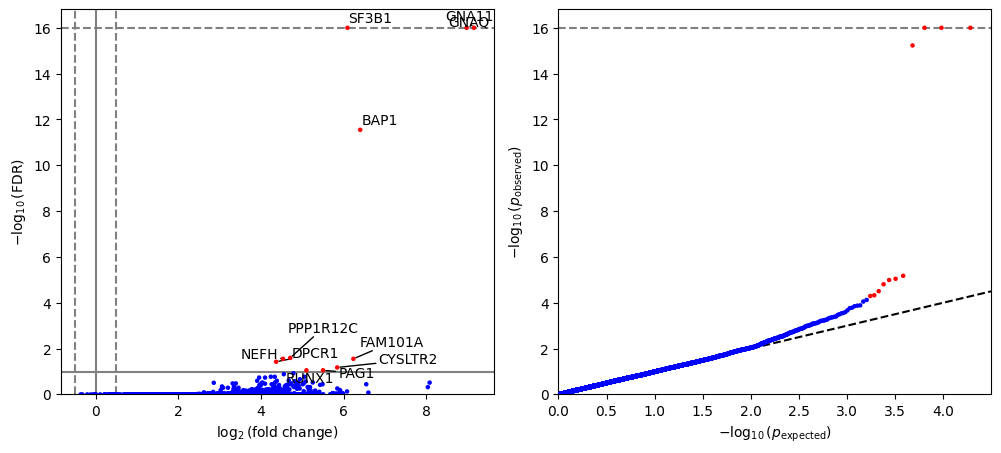

In [16]:
mtype = 'NONSYN'
d = np.log2(df['OBS_' + mtype].to_numpy()) - np.log2(df['EXP_' + mtype].to_numpy())
p_pmid = df['PVAL_' + mtype + '_BURDEN' + '_recomp'].to_numpy()
p_upmid = df['PVAL_' + mtype + '_BURDEN' + '_uniform'].to_numpy()
l = df.GENE.to_numpy()
p_bounds = df[['PVAL_' + mtype + '_BURDEN' + '_lower', 'PVAL_' + mtype + '_BURDEN' + '_upper']].to_numpy()
plot_functions.plot_volcano(p, d, l)
plot_functions.plot_volcano(p_pmid, d, l, ymax_vol=16, ymax_qq=16)
plot_functions.plot_volcano(p_upmid, d, l, ymax_vol=16, ymax_qq=16)

### Q-Q plot for Fisher's combined probability test

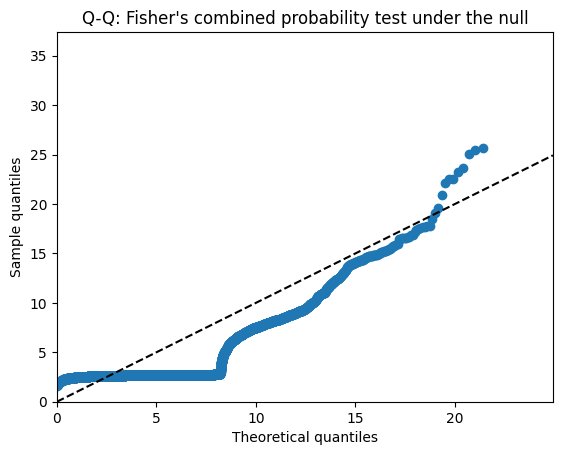

In [78]:
n = df.shape[0]
X = sp.stats.chi2.ppf((np.arange(n-1) + 1) / n, df=4)
Y = np.sort(-2 * np.log(df[['PVAL_NONSYN_BURDEN_recomp', 'PVAL_INDEL_BURDEN_recomp']].to_numpy()).sum(axis=1))
plt.scatter(X, Y[:-1])
plt.plot([0, X.max()], [0, X.max()], 'k--')
plt.xlim([0, X.max()])
plt.ylim([0, 1.5 * X.max()])
plt.title('Q-Q: Fisher\'s combined probability test under the null')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

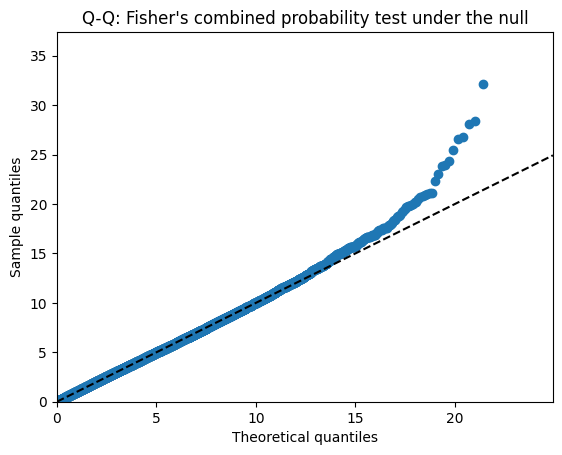

In [81]:
n = df.shape[0]
X = sp.stats.chi2.ppf((np.arange(n-1) + 1) / n, df=4)
Y = np.sort(-2 * np.log(df[['PVAL_NONSYN_BURDEN_uniform', 'PVAL_INDEL_BURDEN_uniform']].to_numpy()).sum(axis=1))
plt.scatter(X, Y[:-1])
plt.plot([0, X.max()], [0, X.max()], 'k--')
plt.xlim([0, X.max()])
plt.ylim([0, 1.5 * X.max()])
plt.title('Q-Q: Fisher\'s combined probability test under the null')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

## Promoters

In [17]:
df_prom = pd.read_csv('promoters.results.txt', sep='\t')
df_prom.columns.tolist()

['ELT',
 'ELT_SIZE',
 'FLAG',
 'R_SIZE',
 'R_OBS',
 'R_INDEL',
 'MU',
 'SIGMA',
 'ALPHA',
 'THETA',
 'MU_INDEL',
 'SIGMA_INDEL',
 'ALPHA_INDEL',
 'THETA_INDEL',
 'Pi_SUM',
 'Pi_INDEL',
 'OBS_SAMPLES',
 'OBS_SNV',
 'OBS_INDEL',
 'EXP_SNV',
 'PVAL_SNV_BURDEN',
 'PVAL_SAMPLE_BURDEN',
 'EXP_INDEL',
 'PVAL_INDEL_BURDEN',
 'PVAL_MUT_BURDEN']

In [18]:
df_prom['OBS_MUT'] = df_prom['OBS_SNV'] + df_prom['OBS_INDEL']
df_prom['EXP_MUT'] = df_prom['EXP_SNV'] + df_prom['EXP_INDEL']
df_prom['Pi_MUT'] = df_prom['Pi_SUM'] + df_prom['Pi_INDEL']

In [19]:
pfxs_obs = ['SNV', 'INDEL', 'SAMPLES', 'MUT']
pfxs_pval = ['SNV', 'INDEL', 'SAMPLE', 'MUT']
pfxs_pi = ['SUM', 'INDEL', 'SUM', 'MUT']
pfxs_at = ['', '_INDEL', '', '']

for i in range(len(pfxs_obs)):
    if pfxs_pval[i]=='MUT':
        col_i = 'PVAL_' + pfxs_pval[i] + '_BURDEN'
        df_prom[col_i + '_recomp'] = np.nan
        df_prom[col_i + '_uniform'] = np.nan
        df_prom[col_i + '_lower'] = np.nan
        df_prom[col_i + '_upper'] = np.nan
        # combining p-values with Fisher's method
        for idx in df_prom.index:
            df_prom.at[idx, col_i + '_recomp'] = sp.stats.combine_pvalues([df_prom.at[idx, 'PVAL_SNV_BURDEN_recomp'], df_prom.at[idx, 'PVAL_INDEL_BURDEN_recomp']], method='fisher').pvalue
            df_prom.at[idx, col_i + '_uniform'] = sp.stats.combine_pvalues([df_prom.at[idx, 'PVAL_SNV_BURDEN_uniform'], df_prom.at[idx, 'PVAL_INDEL_BURDEN_uniform']], method='fisher').pvalue
            df_prom.at[idx, col_i + '_lower'] = sp.stats.combine_pvalues([df_prom.at[idx, 'PVAL_SNV_BURDEN_lower'], df_prom.at[idx, 'PVAL_INDEL_BURDEN_lower']], method='fisher').pvalue
            df_prom.at[idx, col_i + '_upper'] = sp.stats.combine_pvalues([df_prom.at[idx, 'PVAL_SNV_BURDEN_upper'], df_prom.at[idx, 'PVAL_INDEL_BURDEN_upper']], method='fisher').pvalue
    else:
        df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_recomp'] = nb_pvalue_greater_midp(
                df_prom['OBS_' + pfxs_obs[i]],
                df_prom['ALPHA' + pfxs_at[i]],
                1 / (df_prom['THETA' + pfxs_at[i]] * df_prom['Pi_' + pfxs_pi[i]] + 1)
            ) 
        df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_uniform'] = nb_pvalue_uniform_midp(
                df_prom['OBS_' + pfxs_obs[i]],
                df_prom['ALPHA' + pfxs_at[i]],
                1 / (df_prom['THETA' + pfxs_at[i]] * df_prom['Pi_' + pfxs_pi[i]] + 1)
            ) 
        df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_lower'] = nb_pvalue_lower(
            df_prom['OBS_' + pfxs_obs[i]],
            df_prom['ALPHA' + pfxs_at[i]],
            1 / (df_prom['THETA' + pfxs_at[i]] * df_prom['Pi_' + pfxs_pi[i]] + 1)
        )
        df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_upper'] = nb_pvalue_upper(
            df_prom['OBS_' + pfxs_obs[i]],
            df_prom['ALPHA' + pfxs_at[i]],
            1 / (df_prom['THETA' + pfxs_at[i]] * df_prom['Pi_' + pfxs_pi[i]] + 1)
        )
    print(pfxs_obs[i], np.min(df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_recomp'] - df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN']), np.max(df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_recomp'] - df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN']))

SNV -2.4480417692984702e-14 3.197442310920451e-14
INDEL -1.1435297153639112e-14 2.383510055992133e-15
SAMPLES -2.4480417692984702e-14 3.197442310920451e-14
MUT -2.2370993946196904e-14 1.1712852909795402e-14


/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


/var/folders/7d/ccyblkpj6wvbl5n45y_l75180000gq/T/ipykernel_7814/4184195437.py:1: RuntimeWarning: divide by zero encountered in log2
  d = np.log2(df_prom.OBS_MUT.to_numpy()) - np.log2(df_prom.EXP_MUT.to_numpy())
/var/folders/7d/ccyblkpj6wvbl5n45y_l75180000gq/T/ipykernel_7814/4184195437.py:1: RuntimeWarning: invalid value encountered in subtract
  d = np.log2(df_prom.OBS_MUT.to_numpy()) - np.log2(df_prom.EXP_MUT.to_numpy())
/Users/dlehotzk/Documents/tcga/dig/plot_functions.py:82: RuntimeWarning: divide by zero encountered in log10
  logq_bounds = -np.log10(qval_bounds).copy()
/Users/dlehotzk/Documents/tcga/dig/plot_functions.py:125: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.array([x[i]] * 2), -np.log10(pval_bounds[i, :]), color=col[i], alpha=0.15, zorder=10)


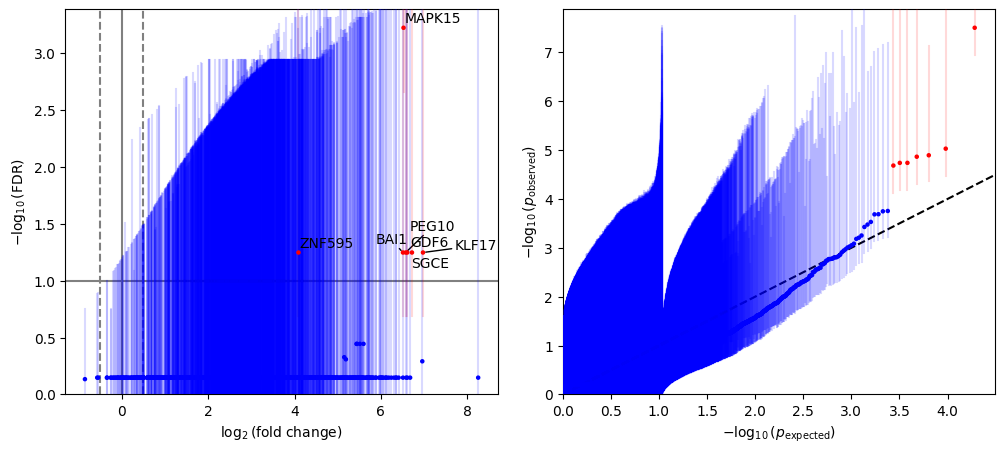

In [20]:
d = np.log2(df_prom.OBS_MUT.to_numpy()) - np.log2(df_prom.EXP_MUT.to_numpy())
p = df_prom.PVAL_MUT_BURDEN_recomp.to_numpy()
l = np.array([g.split('::')[-2] for g in df_prom.ELT])
plot_functions.plot_volcano(p, d, l, pval_bounds=df_prom[['PVAL_MUT_BURDEN_upper', 'PVAL_MUT_BURDEN_lower']].to_numpy())

/var/folders/7d/ccyblkpj6wvbl5n45y_l75180000gq/T/ipykernel_7814/1981111821.py:1: RuntimeWarning: divide by zero encountered in log2
  d = np.log2(df_prom.OBS_MUT.to_numpy()) - np.log2(df_prom.EXP_MUT.to_numpy())
/var/folders/7d/ccyblkpj6wvbl5n45y_l75180000gq/T/ipykernel_7814/1981111821.py:1: RuntimeWarning: invalid value encountered in subtract
  d = np.log2(df_prom.OBS_MUT.to_numpy()) - np.log2(df_prom.EXP_MUT.to_numpy())


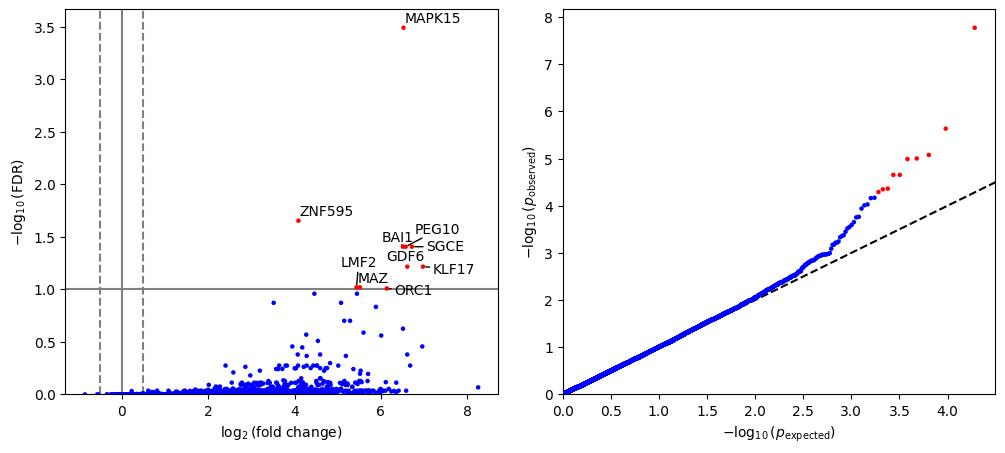

In [21]:
d = np.log2(df_prom.OBS_MUT.to_numpy()) - np.log2(df_prom.EXP_MUT.to_numpy())
p = df_prom.PVAL_MUT_BURDEN_uniform.to_numpy()
l = np.array([g.split('::')[-2] for g in df_prom.ELT])
plot_functions.plot_volcano(p, d, l)

### Q-Q plot for Fisher's combined probability test

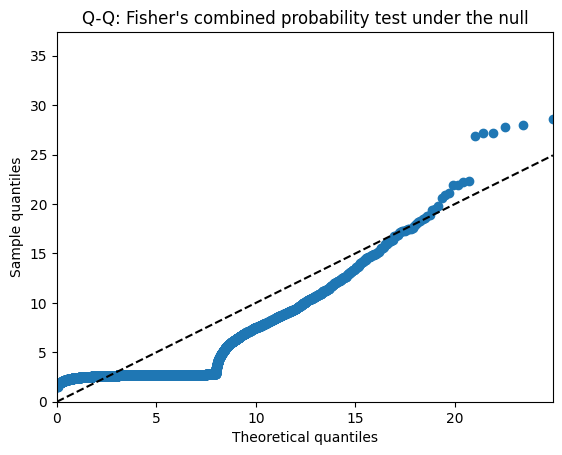

In [79]:
n = df_prom.shape[0]
X = sp.stats.chi2.ppf((np.arange(n-1) + 1) / n, df=4)
Y = np.sort(-2 * np.log(df_prom[['PVAL_SNV_BURDEN', 'PVAL_INDEL_BURDEN']].to_numpy()).sum(axis=1))
plt.scatter(X, Y[:-1])
plt.plot([0, X.max()], [0, X.max()], 'k--')
plt.xlim([0, X.max()])
plt.ylim([0, 1.5 * X.max()])
plt.title('Q-Q: Fisher\'s combined probability test under the null')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

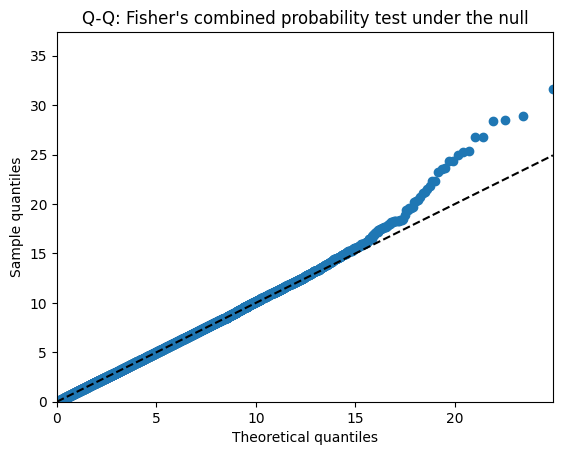

In [80]:
n = df_prom.shape[0]
X = sp.stats.chi2.ppf((np.arange(n-1) + 1) / n, df=4)
Y = np.sort(-2 * np.log(df_prom[['PVAL_SNV_BURDEN_uniform', 'PVAL_INDEL_BURDEN_uniform']].to_numpy()).sum(axis=1))
plt.scatter(X, Y[:-1])
plt.plot([0, X.max()], [0, X.max()], 'k--')
plt.xlim([0, X.max()])
plt.ylim([0, 1.5 * X.max()])
plt.title('Q-Q: Fisher\'s combined probability test under the null')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()